In [1]:
import torch
import torch.nn as nn
import torch.optim as optim
from torchvision import datasets, transforms
from torch.utils.data import Dataset, DataLoader
from sklearn.cluster import KMeans
import matplotlib.pyplot as plt
import numpy as np
from sklearn import decomposition
from tqdm import tqdm
from torchvision.transforms import functional as F
import os
from PIL import Image

In [2]:

class CustomImageDataset(Dataset):
    def __init__(self, root, transform=None):
        self.root = root
        self.transform = transform
        self.image_paths = [os.path.join(root, fname) for fname in os.listdir(root) if fname.endswith('.JPEG') or fname.endswith('jpg')]
        
    def __len__(self):
        return len(self.image_paths)
    
    def __getitem__(self, idx):
        img_path = self.image_paths[idx]
        image = Image.open(img_path).convert("RGB")  # Ensure RGB mode
        
        if self.transform:
            image = self.transform(image)
        
        return image, 0

# Define transformations (ImageNet pre-processing)
transform = transforms.Compose([
    transforms.Resize(256),           # Resize the shorter side to 256
    transforms.CenterCrop(224),       # Crop the image to 224x224
    transforms.ToTensor(),            # Convert the image to a tensor
    transforms.Normalize(             # Normalize using ImageNet mean and std
        mean=[0.485, 0.456, 0.406], 
        std=[0.229, 0.224, 0.225]
    ),
])

# Path to the folder containing JPEG images
data_dir = './random_imagenet'

# Create dataset and dataloader
train_dataset = CustomImageDataset(root=data_dir, transform=transform)
train_loader = DataLoader(train_dataset, batch_size=16, shuffle=True)

# Assuming you have a test set as well in another folder
test_dataset = CustomImageDataset(root=data_dir, transform=transform)
test_loader = DataLoader(test_dataset, batch_size=16, shuffle=False)


In [3]:
class MaskedAutoencoder(nn.Module):
    def __init__(self, latent_dim=512):
        super(MaskedAutoencoder, self).__init__()
        # Encoder
        self.encoder = nn.Sequential(
            nn.Conv2d(3, 16, kernel_size=3, stride=2, padding=1),  # Output: [16, 112, 112]
            nn.ReLU(),
            nn.Conv2d(16, 32, kernel_size=3, stride=2, padding=1),  # Output: [32, 56, 56]
            nn.ReLU(),
            nn.Conv2d(32, 64, kernel_size=3, stride=2, padding=1),  # Output: [64, 28, 28]
            nn.ReLU(),
            nn.Conv2d(64, 128, kernel_size=3, stride=2, padding=1),  # Output: [64, 14, 14]
            nn.ReLU(),
            
        )

        # Latent space
        self.flatten = nn.Flatten()  # Flatten for FC layers
        self.fc1 = nn.Linear(128 * 14 * 14, latent_dim)  # Down to latent_dim
        self.fc2 = nn.Linear(latent_dim, 128 * 14 * 14)  # Back to encoded shape

        # Decoder
        self.decoder = nn.Sequential(
            nn.ConvTranspose2d(128, 64, kernel_size=3, stride=2, padding=1, output_padding=1),  # Output: [64, 14, 14]
            nn.ReLU(),
            nn.ConvTranspose2d(64, 32, kernel_size=3, stride=2, padding=1, output_padding=1),  # Output: [32, 28, 28]
            nn.ReLU(),
            nn.ConvTranspose2d(32, 16, kernel_size=3, stride=2, padding=1, output_padding=1),  # Output: [16, 56, 56]
            nn.ReLU(),
            nn.ConvTranspose2d(16, 3, kernel_size=3, stride=2, padding=1, output_padding=1),  # Output: [3, 112, 112]
            nn.Tanh(),
        )

    def forward(self, x):
        batch_size, channels, height, width = x.size()
        patch_size = height // 4  # Assuming square images (32x32) -> Patch size = 8x8
        patches = x.unfold(2, patch_size, patch_size).unfold(3, patch_size, patch_size)  # Shape: [B, C, 4, 4, 8, 8]

        # Hide two random patches
        patches = patches.contiguous().view(batch_size, channels, 16, patch_size, patch_size)  # [B, C, 16, 8, 8]
        indices = torch.randperm(16)[:2]  # Randomly select 2 patches to hide
        patches[:, :, indices] = 0  # Set selected patches to 0

        # Reassemble the image
        patches = patches.view(batch_size, channels, 4, 4, patch_size, patch_size)  # Reshape back
        masked_image = patches.permute(0, 1, 4, 2, 5, 3).reshape(batch_size, channels, height, width)

        # Encoding
        z = self.encoder(masked_image)
        z = z.view(z.size(0), -1)  # Flatten for the fully connected layer
        z = self.fc1(z)

        # Decoding
        z = self.fc2(z)
        z = z.view(z.size(0), 128, 14, 14)  # Reshape to match decoder input
        x_recon = self.decoder(z)
        return x_recon, z
    

    def save_model(model, optimizer, scheduler, epoch, loss, filename="autoencoder_checkpoint.pth"):
        checkpoint = {
            'epoch': epoch,
            'model_state_dict': model.state_dict(),
            'optimizer_state_dict': optimizer.state_dict(),
            'scheduler_state_dict': scheduler.state_dict(),
            'loss': loss
        }
        torch.save(checkpoint, filename)
        print(f"Model checkpoint saved to {filename}")
    


def save_model(model, optimizer, scheduler, epoch, loss, filename="autoencoder_checkpoint.pth"):
    checkpoint = {
        'epoch': epoch,
        'model_state_dict': model.state_dict(),
        'optimizer_state_dict': optimizer.state_dict(),
        'scheduler_state_dict': scheduler.state_dict(),
        'loss': loss
    }
    torch.save(checkpoint, filename)
    print(f"Model checkpoint saved to {filename}")

def load_model(model, optimizer, scheduler, filename="autoencoder_checkpoint.pth"):
    checkpoint = torch.load(filename)
    model.load_state_dict(checkpoint['model_state_dict'])
    optimizer.load_state_dict(checkpoint['optimizer_state_dict'])
    scheduler.load_state_dict(checkpoint['scheduler_state_dict'])
    epoch = checkpoint['epoch']
    loss = checkpoint['loss']
    print(f"Model checkpoint loaded from {filename}")
    return epoch, loss

In [ ]:
# Define criterion
criterion = nn.MSELoss()

checkpoint_path = "autoenc_checkpoint"

# Training function with cosine annealing learning rate and tqdm progress bar
def train_masked_autoencoder(model, data_loader, epochs=100, lr=0.001):
    model.train()
    optimizer = optim.Adam(model.parameters(), lr=lr)

    # Initialize the scheduler
    scheduler = optim.lr_scheduler.CosineAnnealingLR(optimizer, T_max=epochs, eta_min=0)

    start_epoch = 0
    # Load the checkpoint if it exists
    if os.path.exists(checkpoint_path):
        start_epoch, _ = load_model(model, optimizer, scheduler, checkpoint_path)

    # Iterate over epochs
    for epoch in range(epochs):
        epoch_loss = 0
        # Create a tqdm progress bar for each epoch's batches
        with tqdm(data_loader, desc=f"Epoch {epoch+1}/{epochs}", unit="batch") as pbar:
            for images, _ in pbar:
                #print(images.shape)
                images = images.cuda()
                optimizer.zero_grad()

                # Forward pass
                recon_images, _ = model(images)
                
                # Compute loss
                loss = criterion(recon_images, images)
                loss.backward()
                
                # Update model parameters
                optimizer.step()

                epoch_loss += loss.item()

                # Update the tqdm description with current loss and learning rate
                pbar.set_postfix(loss=loss.item(), lr=scheduler.get_last_lr()[0])
        # Step the learning rate scheduler after each epoch
        scheduler.step()

        save_model(model, optimizer, scheduler, epoch, epoch_loss, checkpoint_path)


# Initialize and train the autoencoder
autoencoder = MaskedAutoencoder().cuda()
train_masked_autoencoder(autoencoder, train_loader)

Epoch 1/100: 100%|██████████| 369/369 [00:53<00:00,  6.84batch/s, loss=0.873, lr=0.001]


Model checkpoint saved to autoenc_checkpoint


Epoch 2/100: 100%|██████████| 369/369 [01:01<00:00,  5.98batch/s, loss=0.793, lr=0.001]


Model checkpoint saved to autoenc_checkpoint


Epoch 3/100: 100%|██████████| 369/369 [00:53<00:00,  6.87batch/s, loss=0.727, lr=0.000999]


Model checkpoint saved to autoenc_checkpoint


Epoch 4/100: 100%|██████████| 369/369 [00:54<00:00,  6.73batch/s, loss=0.842, lr=0.000998]


Model checkpoint saved to autoenc_checkpoint


Epoch 5/100: 100%|██████████| 369/369 [00:54<00:00,  6.77batch/s, loss=0.608, lr=0.000996]


Model checkpoint saved to autoenc_checkpoint


Epoch 6/100: 100%|██████████| 369/369 [00:53<00:00,  6.86batch/s, loss=0.683, lr=0.000994]


Model checkpoint saved to autoenc_checkpoint


Epoch 7/100: 100%|██████████| 369/369 [00:53<00:00,  6.87batch/s, loss=0.656, lr=0.000991]


Model checkpoint saved to autoenc_checkpoint


Epoch 8/100: 100%|██████████| 369/369 [00:53<00:00,  6.91batch/s, loss=0.611, lr=0.000988]


Model checkpoint saved to autoenc_checkpoint


Epoch 9/100: 100%|██████████| 369/369 [00:53<00:00,  6.86batch/s, loss=0.661, lr=0.000984]


Model checkpoint saved to autoenc_checkpoint


Epoch 10/100: 100%|██████████| 369/369 [00:53<00:00,  6.93batch/s, loss=0.723, lr=0.00098]


Model checkpoint saved to autoenc_checkpoint


Epoch 11/100: 100%|██████████| 369/369 [00:52<00:00,  6.98batch/s, loss=0.612, lr=0.000976]


Model checkpoint saved to autoenc_checkpoint


Epoch 12/100: 100%|██████████| 369/369 [00:53<00:00,  6.96batch/s, loss=0.693, lr=0.00097]


Model checkpoint saved to autoenc_checkpoint


Epoch 13/100: 100%|██████████| 369/369 [00:52<00:00,  7.07batch/s, loss=0.716, lr=0.000965]


Model checkpoint saved to autoenc_checkpoint


Epoch 14/100: 100%|██████████| 369/369 [00:52<00:00,  7.06batch/s, loss=0.546, lr=0.000959]


Model checkpoint saved to autoenc_checkpoint


Epoch 15/100: 100%|██████████| 369/369 [00:52<00:00,  7.00batch/s, loss=0.643, lr=0.000952]


Model checkpoint saved to autoenc_checkpoint


Epoch 16/100: 100%|██████████| 369/369 [00:53<00:00,  6.94batch/s, loss=0.621, lr=0.000946]


Model checkpoint saved to autoenc_checkpoint


Epoch 17/100: 100%|██████████| 369/369 [01:05<00:00,  5.63batch/s, loss=0.63, lr=0.000938] 


Model checkpoint saved to autoenc_checkpoint


Epoch 18/100: 100%|██████████| 369/369 [01:18<00:00,  4.72batch/s, loss=0.663, lr=0.00093]


Model checkpoint saved to autoenc_checkpoint


Epoch 19/100: 100%|██████████| 369/369 [01:06<00:00,  5.52batch/s, loss=0.496, lr=0.000922]


Model checkpoint saved to autoenc_checkpoint


Epoch 20/100: 100%|██████████| 369/369 [00:56<00:00,  6.52batch/s, loss=0.67, lr=0.000914] 


Model checkpoint saved to autoenc_checkpoint


Epoch 21/100: 100%|██████████| 369/369 [01:00<00:00,  6.13batch/s, loss=0.465, lr=0.000905]


Model checkpoint saved to autoenc_checkpoint


Epoch 22/100: 100%|██████████| 369/369 [01:02<00:00,  5.86batch/s, loss=0.545, lr=0.000895]


Model checkpoint saved to autoenc_checkpoint


Epoch 23/100: 100%|██████████| 369/369 [01:04<00:00,  5.69batch/s, loss=0.518, lr=0.000885]


Model checkpoint saved to autoenc_checkpoint


Epoch 24/100: 100%|██████████| 369/369 [01:04<00:00,  5.76batch/s, loss=0.624, lr=0.000875]


Model checkpoint saved to autoenc_checkpoint


Epoch 25/100: 100%|██████████| 369/369 [01:05<00:00,  5.62batch/s, loss=0.462, lr=0.000864]


Model checkpoint saved to autoenc_checkpoint


Epoch 26/100: 100%|██████████| 369/369 [00:52<00:00,  7.02batch/s, loss=0.468, lr=0.000854]


Model checkpoint saved to autoenc_checkpoint


Epoch 27/100: 100%|██████████| 369/369 [00:54<00:00,  6.83batch/s, loss=0.45, lr=0.000842] 


Model checkpoint saved to autoenc_checkpoint


Epoch 28/100:  53%|█████▎    | 197/369 [00:30<00:33,  5.13batch/s, loss=0.441, lr=0.000831]

(3, 224, 224)


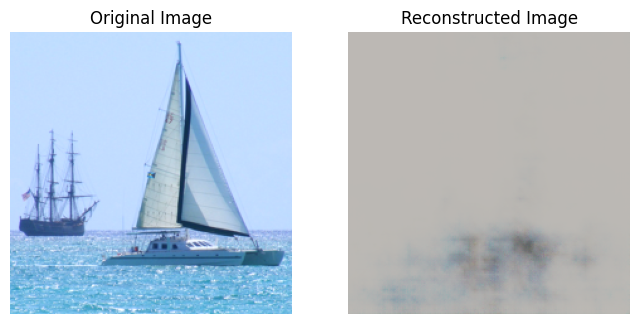

In [ ]:

def reverse_normalize(tensor, mean, std):
    mean = np.array(mean).reshape(1, 3, 1, 1)
    std = np.array(std).reshape(1, 3, 1, 1)
    return tensor * std + mean

def visualize_reconstruction(model, data_loader, mean, std):
    model.eval()
    with torch.no_grad():
        # Get a batch of test images
        for images, _ in data_loader:
            images = images.cuda()
            # Forward pass through the autoencoder
            reconstructed, _ = model(images)
            break

    # Select one image for visualization
    original_image = images[0].cpu()
    reconstructed_image = reconstructed[0].cpu()

    # Reverse normalization
    original_image = reverse_normalize(original_image, mean, std).numpy()
    reconstructed_image = reverse_normalize(reconstructed_image, mean, std).numpy()

    # Clip values to [0, 1] for display
    original_image = np.clip(original_image, 0, 1)
    reconstructed_image = np.clip(reconstructed_image, 0, 1)

    # Transpose for matplotlib (C, H, W) -> (H, W, C)

    print(original_image.squeeze(0).shape)
    original_image = np.transpose(original_image.squeeze(0), (1, 2, 0))
    reconstructed_image = np.transpose(reconstructed_image.squeeze(0), (1, 2, 0))

    # Plot the images
    plt.figure(figsize=(8, 4))
    plt.subplot(1, 2, 1)
    plt.title("Original Image")
    plt.imshow(original_image)
    plt.axis("off")

    plt.subplot(1, 2, 2)
    plt.title("Reconstructed Image")
    plt.imshow(reconstructed_image)
    plt.axis("off")

    plt.show()

# Mean and std for CIFAR-10 normalization
cifar10_mean = [0.4914, 0.4822, 0.4465]
cifar10_std = [0.247, 0.243, 0.261]

# Visualize reconstruction
visualize_reconstruction(autoencoder, test_loader, mean=cifar10_mean, std=cifar10_std)

In [ ]:
def extract_features(model, data_loader):
    model.eval()
    features = []
    with torch.no_grad():
        for images, _ in data_loader:
            images = images.cuda()
            _, z = model(images)
            features.append(z.view(z.size(0), -1).cpu().numpy())  # Flatten
    return np.vstack(features)

# Extract features from train and test sets
train_features = extract_features(autoencoder, train_loader)
test_features = extract_features(autoencoder, test_loader)


In [ ]:
def plot_pca(features, labels, title="PCA Visualization"):
    # Reduce to 2 dimensions using PCA
    pca = decomposition.PCA(n_components=2)
    reduced_features = pca.fit_transform(features)
    
    # Create a scatter plot
    plt.figure(figsize=(10, 10))
    for label in np.unique(labels):
        mask = labels == label
        plt.scatter(reduced_features[mask, 0], reduced_features[mask, 1], label=f"Class {label}", s=10)
    
    plt.title(title)
    plt.xlabel("Principal Component 1")
    plt.ylabel("Principal Component 2")
    plt.legend()
    plt.grid(True)
    plt.show()

# Visualize train features
train_labels = np.array(train_dataset.targets)  # Get true labels for train set
plot_pca(train_features, train_labels, title="PCA Visualization of Train Features")

# Visualize test features
test_labels = np.array(test_dataset.targets)  # Get true labels for test set
plot_pca(test_features, test_labels, title="PCA Visualization of Test Features")

AttributeError: 'CustomImageDataset' object has no attribute 'targets'

In [ ]:
# Apply K-Means clustering
kmeans = KMeans(n_clusters=10, random_state=0).fit(train_features)
train_labels = kmeans.labels_

# Assign cluster labels to test data
test_labels = kmeans.predict(test_features)


In [ ]:
from scipy.stats import mode

def map_clusters_to_labels(cluster_labels, true_labels):
    cluster_mapping = {}
    for cluster in np.unique(cluster_labels):
        mask = cluster_labels == cluster
        if np.sum(mask) == 0:
            continue  # Skip empty clusters
        most_common_label = mode(true_labels[mask]).mode
        if isinstance(most_common_label, np.ndarray) and most_common_label.size > 0:
            cluster_mapping[cluster] = most_common_label[0]
        else:
            cluster_mapping[cluster] = -1  # Fallback label for empty cases
    return cluster_mapping

# Evaluate clustering quality (requires true labels)
train_targets = np.array(train_dataset.targets)
test_targets = np.array(test_dataset.targets)

cluster_mapping = map_clusters_to_labels(train_labels, train_targets)
predicted_test_labels = np.array([cluster_mapping[cluster] for cluster in test_labels])

accuracy = np.mean(predicted_test_labels == test_targets)
print(f"Clustering Accuracy: {accuracy * 100:.2f}%")


Clustering Accuracy: 0.00%


In [ ]:
""" 
from sklearn.manifold import TSNE

def visualize_embeddings(embeddings, labels):
    tsne = TSNE(n_components=2, random_state=42)
    reduced_embeddings = tsne.fit_transform(embeddings)

    plt.figure(figsize=(10, 10))
    for label in np.unique(labels):
        idx = labels == label
        plt.scatter(reduced_embeddings[idx, 0], reduced_embeddings[idx, 1], label=f"Cluster {label}", s=10)
    plt.legend()
    plt.show()

# Visualize train embeddings
visualize_embeddings(train_features, train_labels)
"""


' \nfrom sklearn.manifold import TSNE\n\ndef visualize_embeddings(embeddings, labels):\n    tsne = TSNE(n_components=2, random_state=42)\n    reduced_embeddings = tsne.fit_transform(embeddings)\n\n    plt.figure(figsize=(10, 10))\n    for label in np.unique(labels):\n        idx = labels == label\n        plt.scatter(reduced_embeddings[idx, 0], reduced_embeddings[idx, 1], label=f"Cluster {label}", s=10)\n    plt.legend()\n    plt.show()\n\n# Visualize train embeddings\nvisualize_embeddings(train_features, train_labels)\n'